# SETUP

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from warnings import filterwarnings
from scipy.stats import skew, f_oneway, spearmanr
import os

import pickle

from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler

filterwarnings('ignore')  # Suppress warnings for cleaner output
pd.set_option('display.max_columns', None)  # Display all columns in DataFrames
plt.style.use('ggplot')  # Set default plotting style

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

In [ ]:
TRAIN_PATH = '../raw/data/train-pollution.csv'
TEST_PATH = '../raw/data/test-pollution.csv'
SAMPLE_SUBMISSION_PATH = '../data/example-submition.csv'

In [18]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

# DATASET

In [19]:
data = {
    'x': 1,
    'y': 2
}

pd.DataFrame([data])

,x,y
0,1,2


In [20]:
def summary(df):

    print(f"Shape: {df.shape}")

    print("\nFeatures:")
    for i, col in enumerate(df.columns):
        print(f"{i+1}. {col}")
    
    print("\nSummary:")

    summ = pd.DataFrame({
        'Dtype': df.dtypes,
        'Total Missing': df.isnull().sum(),
        'Total Missing (%)': df.isnull().mean() * 100,
        'Unique Values': df.nunique()
    })

    summ['Total Missing (%)'] = summ['Total Missing (%)'].round(2)
    summ.sort_values(by='Total Missing (%)', ascending=False, inplace=True)
    display(summ)

    print("\nSample Data:")
    display(df.head())

summary(train)




Shape: (8000, 11)

Features:
1. ID
2. Temperature
3. Humidity
4. PM2.5
5. PM10
6. NO2
7. SO2
8. CO
9. Proximity_to_Industrial_Areas
10. Population_Density
11. Air Quality

Summary:


,Dtype,Total Missing,Total Missing (%),Unique Values
ID,int64,0,0.0,8000
Temperature,float64,0,0.0,361
Humidity,float64,0,0.0,745
PM2.5,float64,0,0.0,896
PM10,float64,0,0.0,1039
NO2,float64,0,0.0,441
SO2,float64,0,0.0,388
CO,float64,0,0.0,261
Proximity_to_Industrial_Areas,float64,0,0.0,175
Population_Density,int64,0,0.0,696



Sample Data:


,ID,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,1097,23.1,66.2,30.0,36.4,16.2,5.2,1.07,17.1,210,Good
1,1626,19.8,66.7,9.0,13.3,14.5,2.7,0.94,11.0,374,Good
2,7867,34.6,79.8,7.5,14.6,27.8,18.1,1.63,5.4,542,Moderate
3,2550,31.4,59.1,5.6,10.8,21.0,2.9,0.96,10.5,442,Good
4,601,28.0,75.4,9.1,18.6,33.0,8.7,1.46,7.1,620,Moderate


In [21]:
print("Total Duplicate Rows:", train.duplicated().sum())

Total Duplicate Rows: 0


In [22]:
summary(test)

Shape: (2000, 10)

Features:
1. ID
2. Temperature
3. Humidity
4. PM2.5
5. PM10
6. NO2
7. SO2
8. CO
9. Proximity_to_Industrial_Areas
10. Population_Density

Summary:


,Dtype,Total Missing,Total Missing (%),Unique Values
ID,int64,0,0.0,2000
Temperature,float64,0,0.0,297
Humidity,float64,0,0.0,606
PM2.5,float64,0,0.0,539
PM10,float64,0,0.0,634
NO2,float64,0,0.0,371
SO2,float64,0,0.0,302
CO,float64,0,0.0,223
Proximity_to_Industrial_Areas,float64,0,0.0,155
Population_Density,int64,0,0.0,588



Sample Data:


,ID,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
0,6154,23.4,71.4,31.8,47.1,25.2,9.5,1.90,5.1,658
1,2689,38.1,71.8,56.3,67.2,26.6,-0.7,1.70,6.4,377
2,4687,28.8,52.5,39.8,45.1,27.5,6.8,1.55,11.0,377
3,6634,29.6,74.8,49.9,56.2,17.8,6.2,1.05,12.4,336
4,3704,32.3,63.1,1.2,12.5,29.3,16.5,2.14,5.2,547


In [23]:
train.drop("ID", axis=1, inplace=True)
test.drop("ID", axis=1, inplace=True)

In [24]:
train.columns = [col.lower() for col in train.columns]
test.columns = [col.lower() for col in test.columns]

In [25]:
submission.shape

(2000, 2)

In [26]:
numeric = train.select_dtypes(include=['number']).columns.tolist()

In [8]:
print("Statistical Summary of Numeric Features in Train:")
display(train[numeric].describe().T)

Statistical Summary of Numeric Features in Train:


,count,mean,std,min,25%,50%,75%,max
temperature,8000.0,30.140150,6.406995,13.70,25.30,29.20,34.50,57.20
humidity,8000.0,70.083425,14.984660,36.10,59.20,69.80,79.60,125.10
pm2.5,8000.0,18.350325,23.506473,0.00,4.30,10.70,22.60,262.10
pm10,8000.0,28.151112,26.140800,-0.20,11.70,20.50,34.40,307.50
no2,8000.0,26.039963,8.390466,9.00,20.20,25.10,31.00,60.10
so2,8000.0,9.638483,6.741046,-5.90,4.80,7.70,13.50,44.70
co,8000.0,1.477163,0.525186,0.66,1.02,1.39,1.81,3.67
proximity_to_industrial_areas,8000.0,8.350087,3.408291,2.50,5.40,7.80,11.00,21.70
population_density,8000.0,490.365750,149.009016,188.00,379.00,488.00,591.00,949.00


In [9]:
print("Statistical Summary of Numeric Features in Test:")
display(test[numeric].describe().T)

Statistical Summary of Numeric Features in Test:


,count,mean,std,min,25%,50%,75%,max
temperature,2000.0,30.196700,6.407913,15.40,25.400,29.20,34.400,55.50
humidity,2000.0,70.042800,14.975434,36.20,59.200,69.70,79.825,118.20
pm2.5,2000.0,18.019800,22.459489,0.00,4.200,10.85,22.800,257.90
pm10,2000.0,27.920250,25.096392,1.30,12.000,20.70,33.900,282.30
no2,2000.0,26.026850,8.286710,10.00,20.300,25.10,31.000,59.50
so2,2000.0,9.512200,6.619356,-4.40,4.775,7.60,13.500,42.80
co,2000.0,1.484555,0.529507,0.72,1.020,1.41,1.820,3.54
proximity_to_industrial_areas,2000.0,8.352600,3.493397,2.50,5.400,7.60,11.000,25.20
population_density,2000.0,492.251000,148.399259,192.00,377.750,493.00,595.000,957.00


In [12]:
LABEL = "air quality"

# EDA

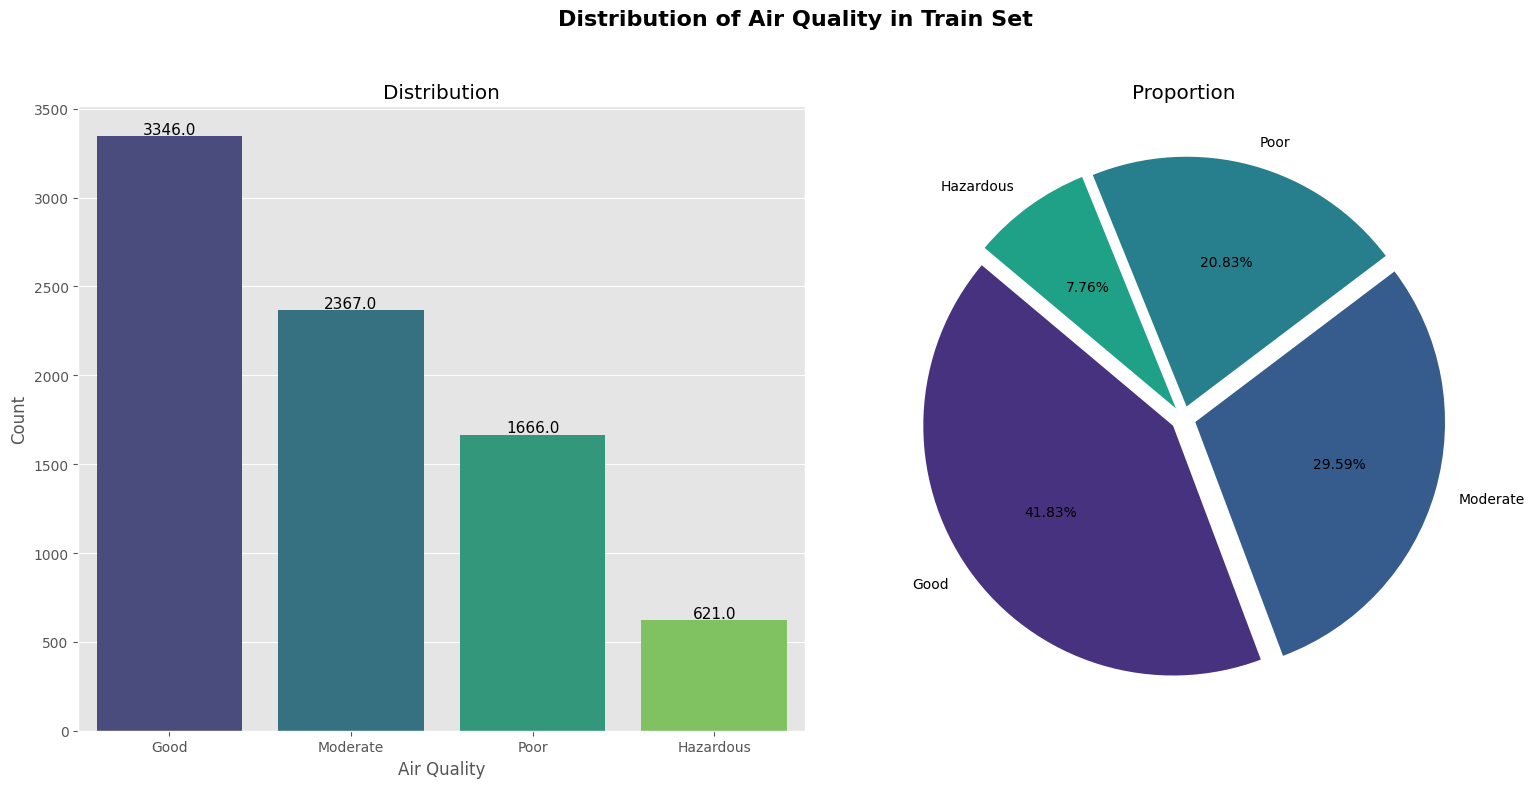

In [26]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.suptitle("Distribution of Air Quality in Train Set", fontsize = 16, fontweight = 'bold')
sns.countplot(data = train, x = LABEL, order=train[LABEL].value_counts().index, palette = "viridis")
plt.xlabel("Air Quality")
plt.ylabel("Count")
plt.title("Distribution")

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', fontsize = 11, color = 'black', xytext = (0, 5), 
                       textcoords = 'offset points')
    
plt.subplot(1, 2, 2)
train[LABEL].value_counts().plot.pie(autopct = '%.2f%%', colors = sns.color_palette("viridis"), startangle = 140, explode = [0.05]*train[LABEL].nunique())
plt.title("Proportion")
plt.ylabel("")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
    

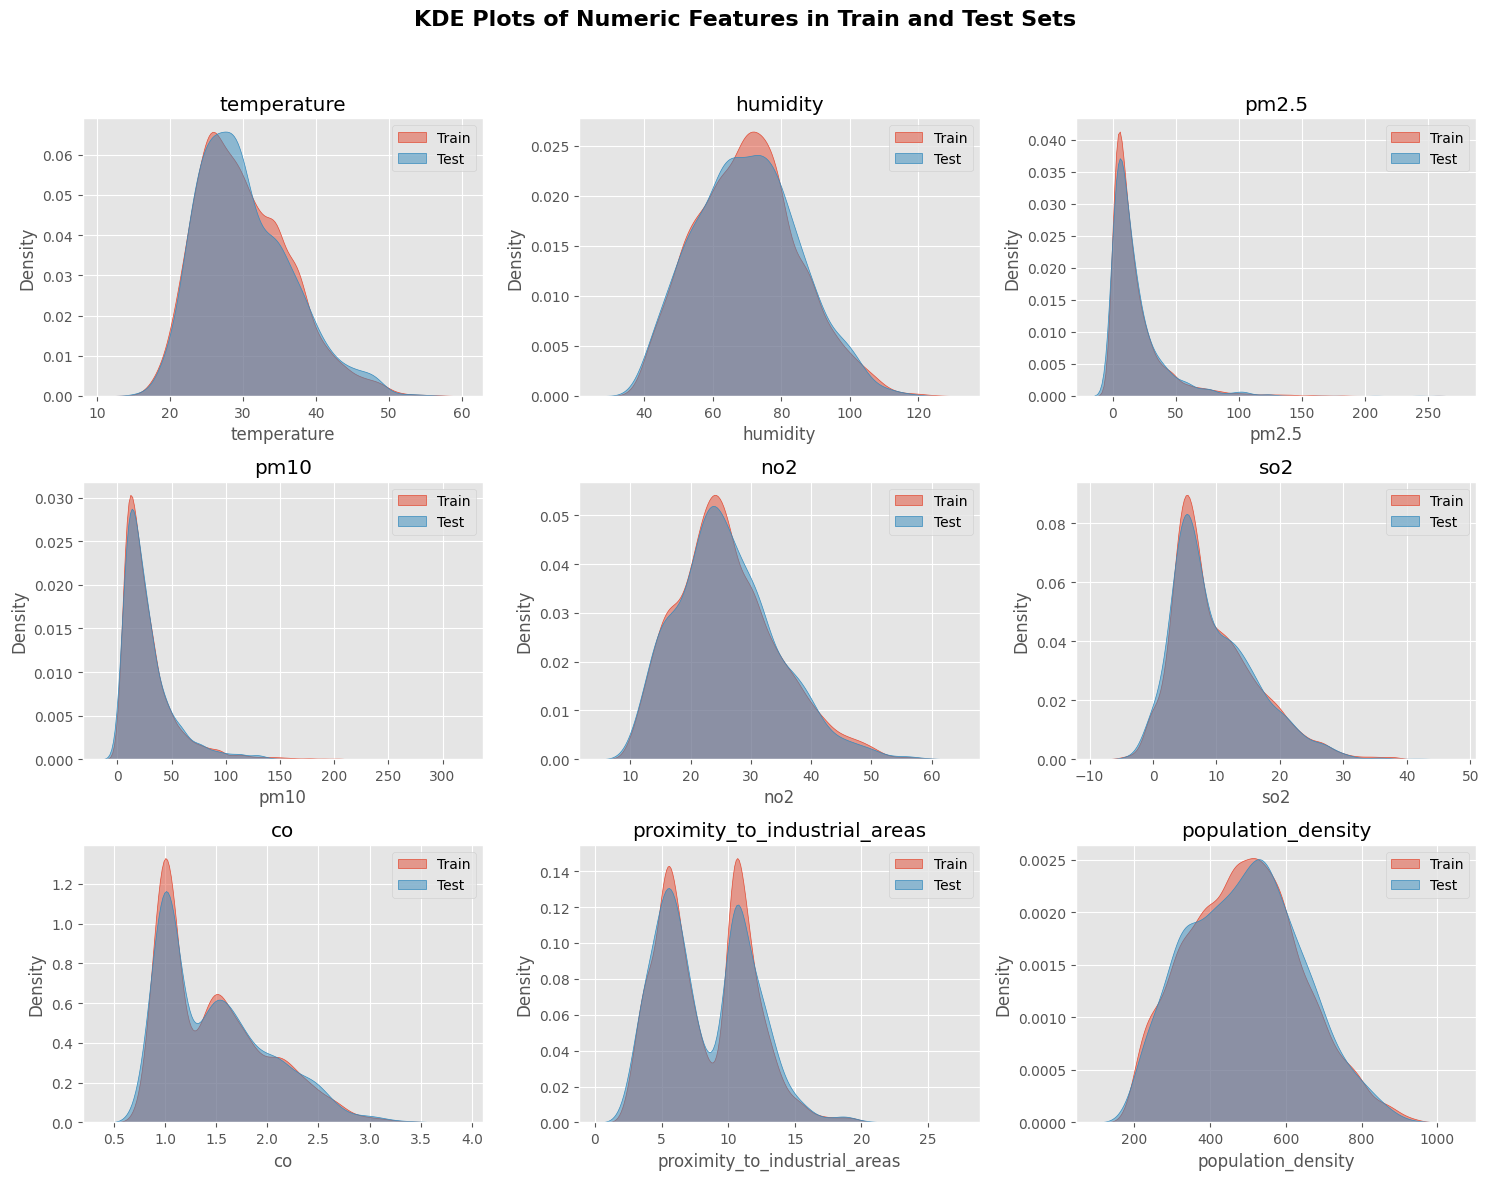

In [28]:
def kde_plot(train, test, numeric):
    length = len(numeric)
    cols = 3
    rows = length // cols + int(length % cols > 0)
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.suptitle('KDE Plots of Numeric Features in Train and Test Sets', fontsize=16, fontweight='bold')
    for i, col in enumerate(numeric):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(train[col], label='Train', fill=True, alpha=0.5)
        sns.kdeplot(test[col], label='Test', fill=True, alpha=0.5)
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
kde_plot(train, test, numeric)

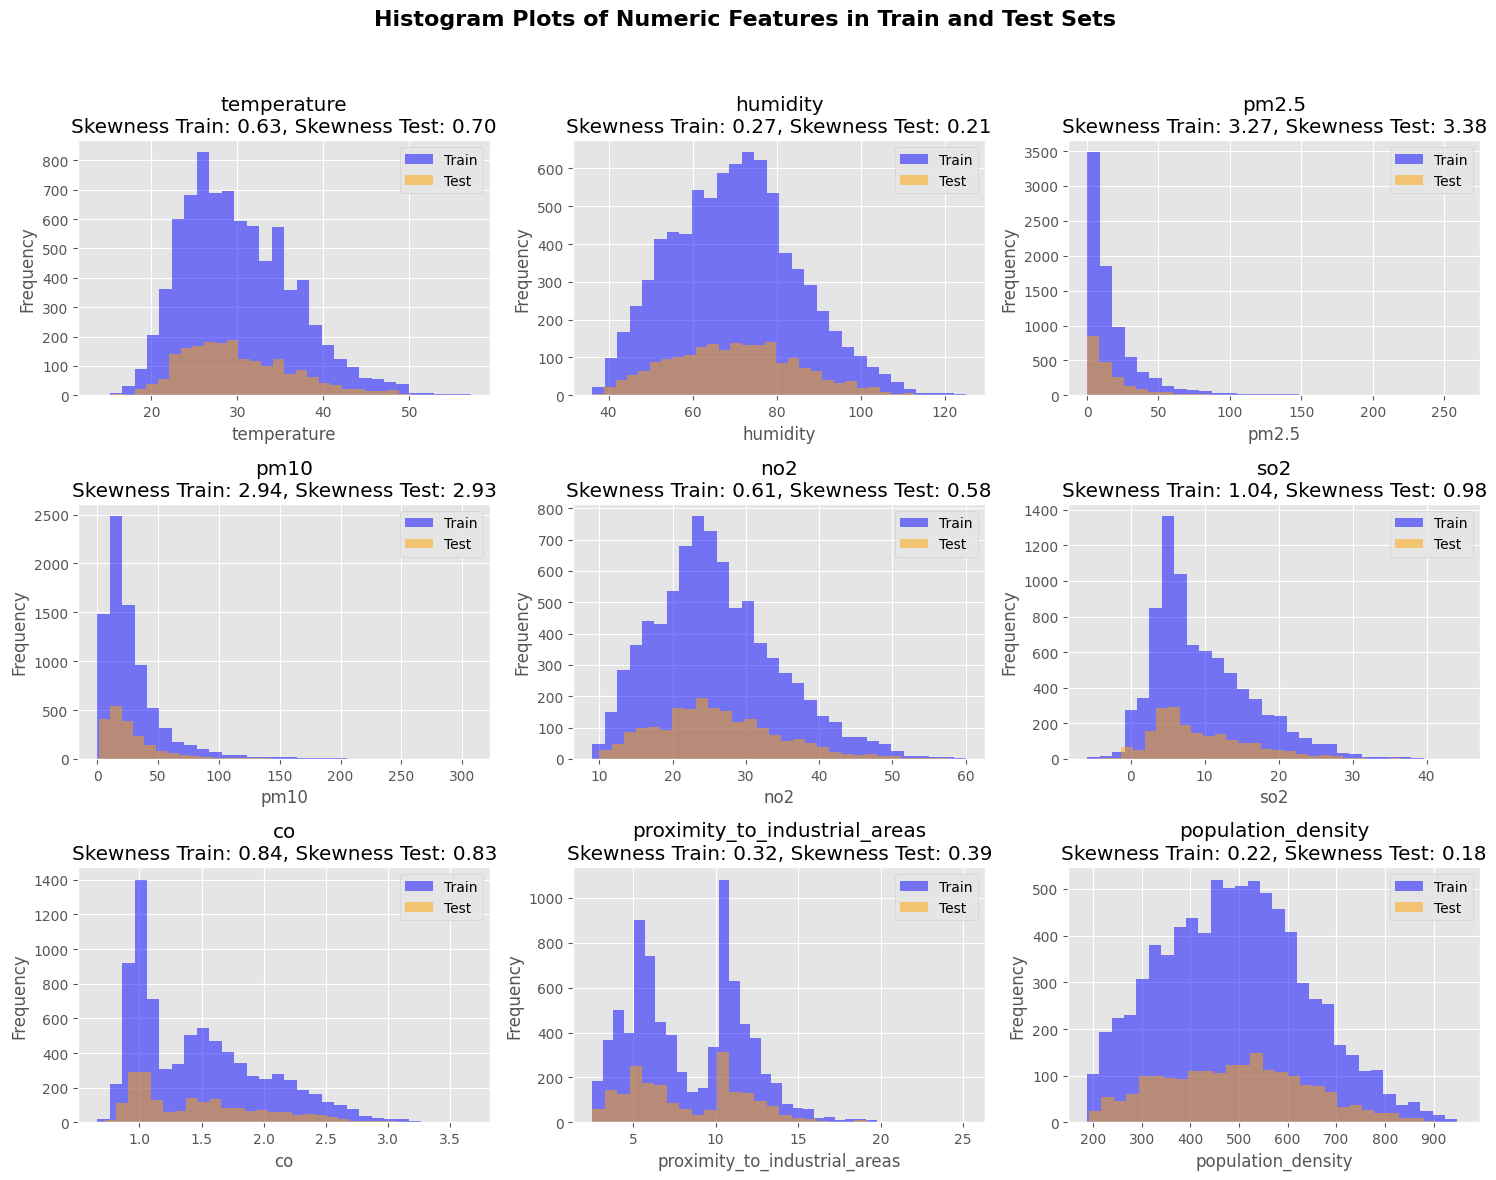

In [30]:
def hist_plot(train, test, numeric):
    length = len(numeric)
    cols = 3
    rows = length // cols + int(length % cols > 0)
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.suptitle('Histogram Plots of Numeric Features in Train and Test Sets', fontsize=16, fontweight='bold')
    for i, col in enumerate(numeric):
        plt.subplot(rows, cols, i + 1)
        plt.hist(train[col], bins=30, alpha=0.5, label='Train', color='blue')
        plt.hist(test[col], bins=30, alpha=0.5, label='Test', color='orange')
        plt.title(f'{col}\nSkewness Train: {skew(train[col]):.2f}, Skewness Test: {skew(test[col]):.2f}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
hist_plot(train, test, numeric)

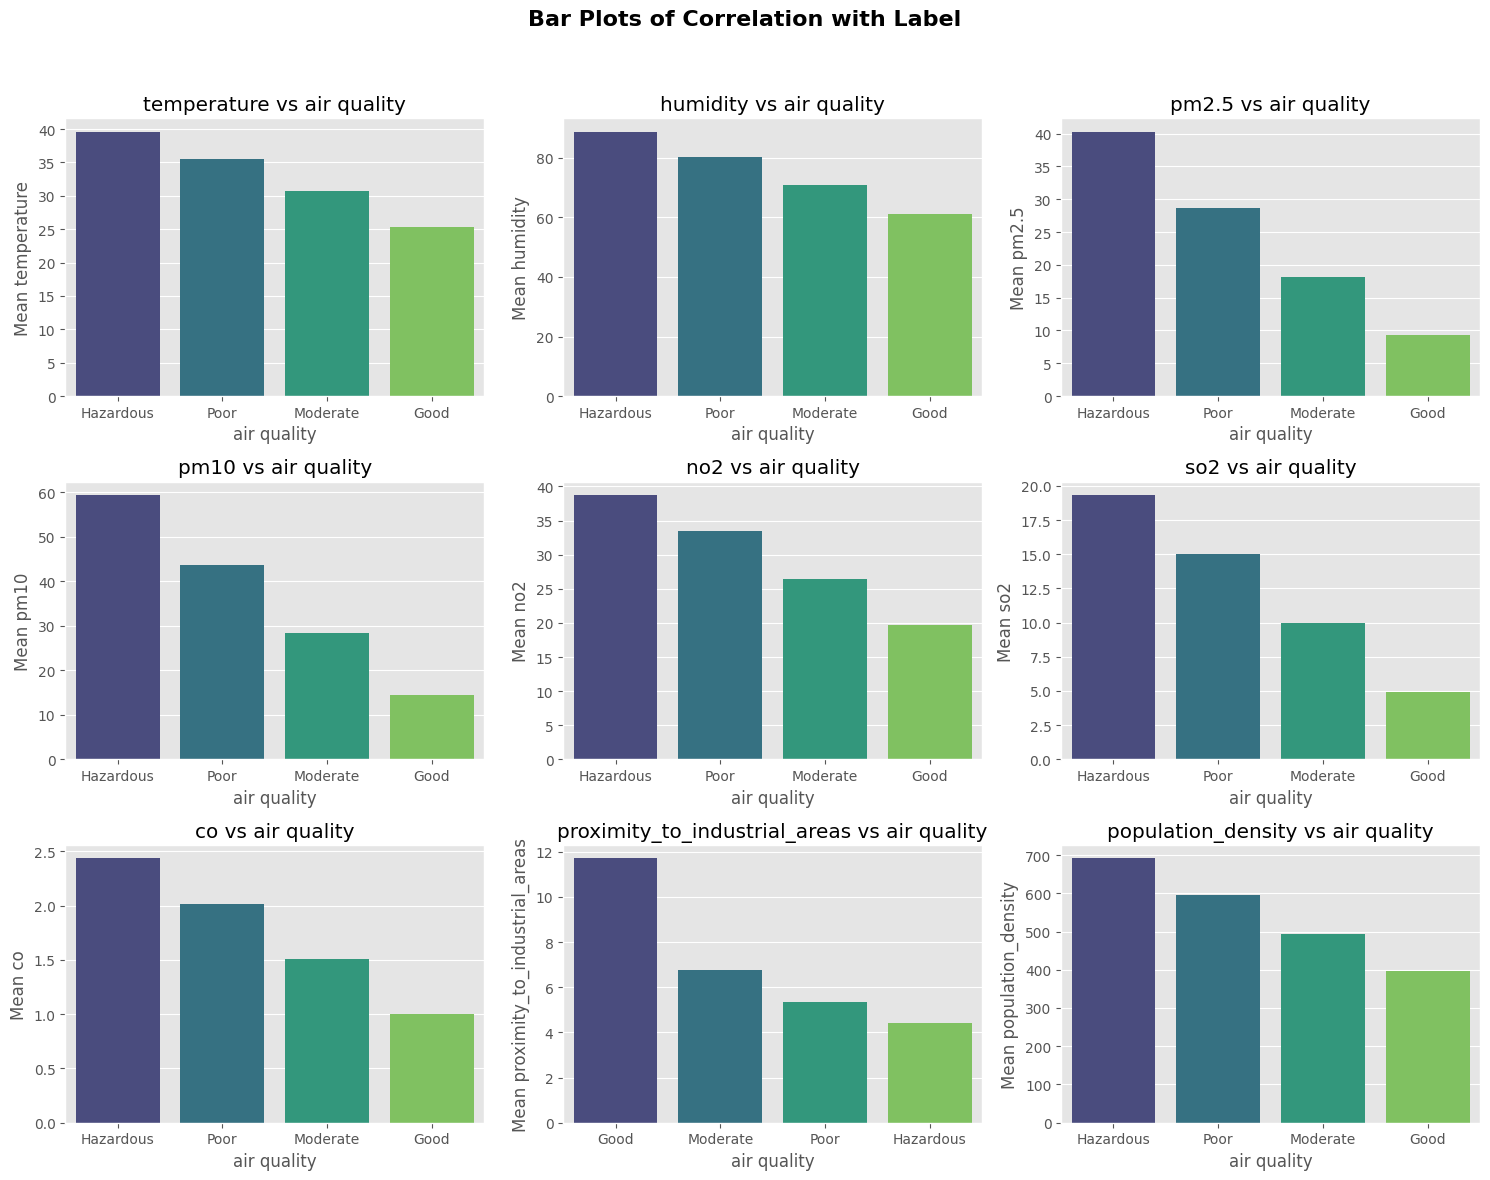

In [37]:
def bar_corr_label_plot(train, numeric, label):
    length = len(numeric) - 1  # Exclude label from count
    cols = 3
    rows = length // cols + int(length % cols > 0)
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.suptitle('Bar Plots of Correlation with Label', fontsize=16, fontweight='bold')
    for i, col in enumerate(numeric):
        group = train.groupby(label)[col].mean().reset_index()
        plt.subplot(rows, cols, i + 1)
        sns.barplot(x=label, y=col, data=group, palette='viridis', order=group.sort_values(by=col, ascending=False)[label])
        plt.title(f'{col} vs {label}')
        plt.xlabel(label)
        plt.ylabel(f'Mean {col}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
bar_corr_label_plot(train, numeric, LABEL)

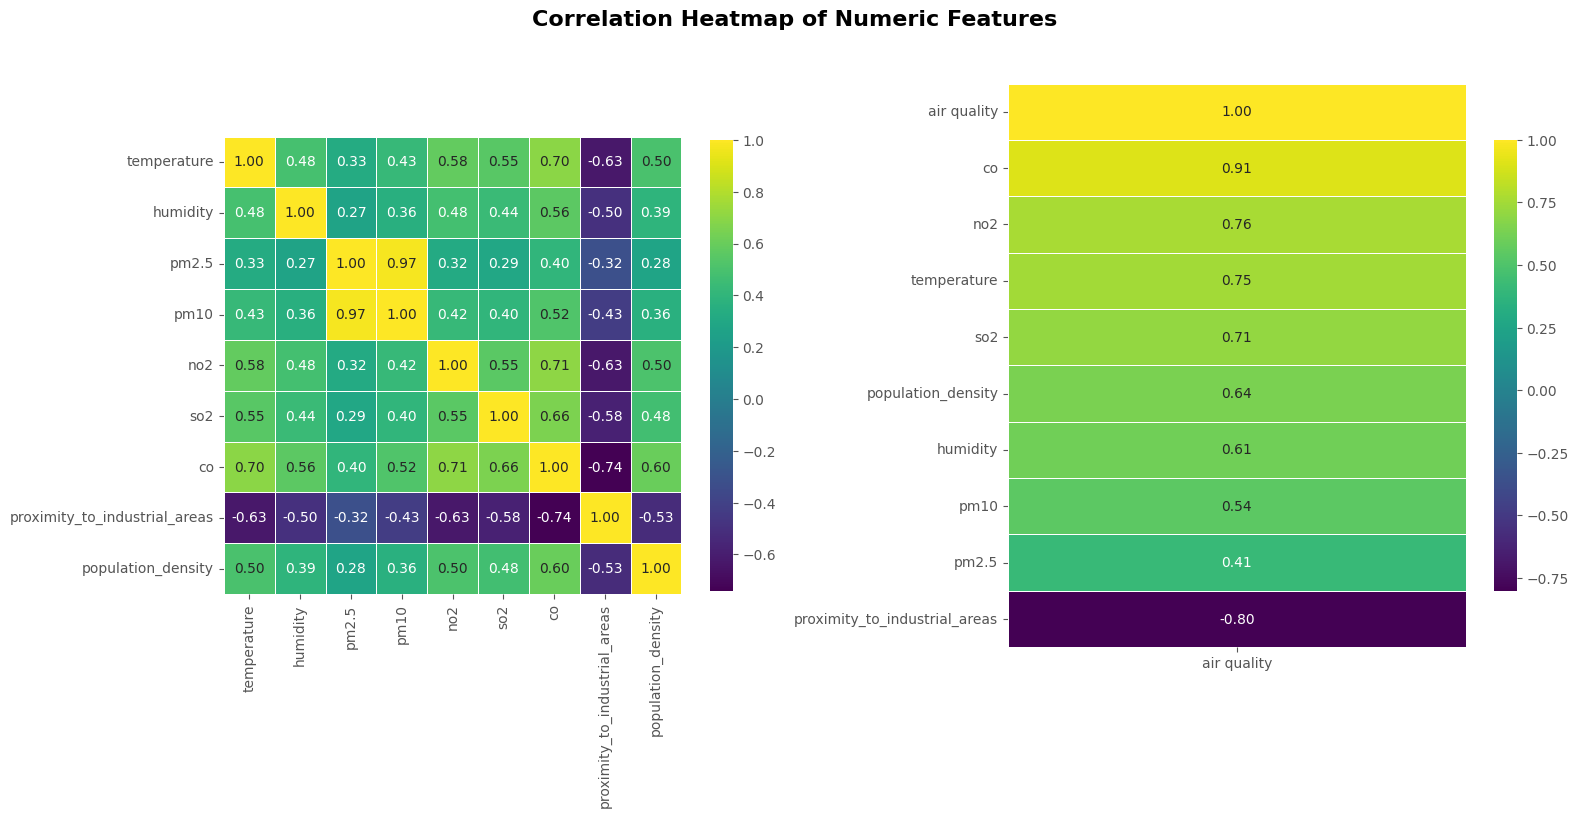

In [46]:
def heatmap_plot(train, numeric):
    plt.figure(figsize=(16, 8))
    plt.suptitle('Correlation Heatmap of Numeric Features', fontsize=16, fontweight='bold')
    corr = train[numeric].corr()
    plt.subplot(1, 2, 1)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', square=True, cbar_kws={"shrink": .8}, linewidths=.5)

    plt.subplot(1, 2, 2)
    train_cpy = train.copy()
    train_cpy[LABEL] = train_cpy[LABEL].map({'Good': 0, 'Moderate': 1, 'Poor': 2, 'Hazardous': 3}).astype(int)
    numeric_cpy = train_cpy.select_dtypes(include=['number']).columns.tolist()
    corr_label = train_cpy[numeric_cpy].corr()[LABEL].sort_values(ascending=False)
    sns.heatmap(corr_label.to_frame(), annot=True, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8}, linewidths=.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
heatmap_plot(train, numeric)

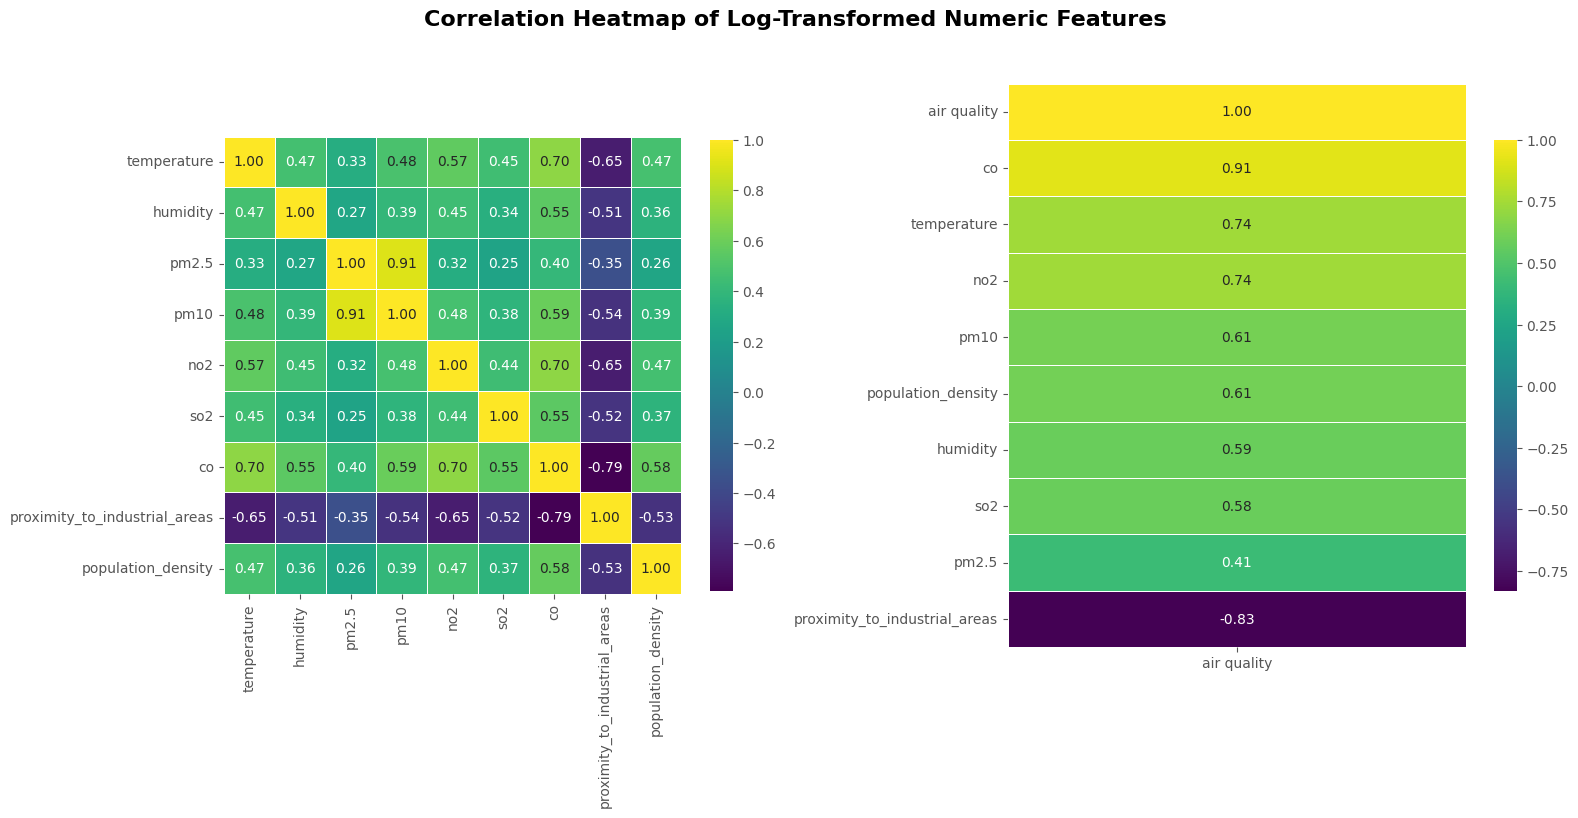

In [52]:
train_log = train.copy()
for col in numeric:
    if col != LABEL:
        train_log[col] = np.log1p(train_log[col])

def heatmap_plot_log(train_log, numeric):
    plt.figure(figsize=(16, 8))
    plt.suptitle('Correlation Heatmap of Log-Transformed Numeric Features', fontsize=16, fontweight='bold')
    corr = train_log[numeric].corr()
    plt.subplot(1, 2, 1)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', square=True, cbar_kws={"shrink": .8}, linewidths=.5)

    plt.subplot(1, 2, 2)
    train_log_cpy = train_log.copy()
    train_log_cpy[LABEL] = train_log_cpy[LABEL].map({'Good': 0, 'Moderate': 1, 'Poor': 2, 'Hazardous': 3}).astype(int)
    numeric_cpy = train_log_cpy.select_dtypes(include=['number']).columns.tolist()
    corr_label = train_log_cpy[numeric_cpy].corr()[LABEL].sort_values(ascending=False)
    sns.heatmap(corr_label.to_frame(), annot=True, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8}, linewidths=.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
heatmap_plot_log(train_log, numeric)

In [54]:
train_cpy = train.copy()
test_cpy = test.copy()

# FEATURE ENGINEERING

In [55]:
# def add_feature(df):
#     df['dew_point_proxy'] = df['temperature'] - ((100 - df['humidity']) / 5)

#     return df

# train_cpy = add_feature(train_cpy)
# test_cpy = add_feature(test_cpy)

In [56]:
train_cpy

,temperature,humidity,pm2.5,pm10,no2,so2,co,proximity_to_industrial_areas,population_density,air quality
0,23.1,66.2,30.0,36.4,16.2,5.2,1.07,17.1,210,Good
1,19.8,66.7,9.0,13.3,14.5,2.7,0.94,11.0,374,Good
2,34.6,79.8,7.5,14.6,27.8,18.1,1.63,5.4,542,Moderate
3,31.4,59.1,5.6,10.8,21.0,2.9,0.96,10.5,442,Good
4,28.0,75.4,9.1,18.6,33.0,8.7,1.46,7.1,620,Moderate
...,...,...,...,...,...,...,...,...,...,...
7995,31.7,72.6,5.4,16.5,22.6,6.6,1.37,6.5,505,Moderate
7996,35.4,68.5,15.5,28.1,41.3,9.2,2.69,7.0,710,Hazardous
7997,20.0,57.5,2.1,5.7,19.3,4.3,0.89,10.4,392,Good
7998,30.0,80.1,48.9,55.8,21.2,9.3,1.43,9.0,444,Moderate


# PREPROCESSING

In [57]:
train_cpy[LABEL] = train_cpy[LABEL].map({'Good': 0, 'Moderate': 1, 'Poor': 2, 'Hazardous': 3}).astype(int)

scaler = RobustScaler()
numeric = [col for col in train_cpy.select_dtypes(include=['number']).columns if col != LABEL]
train_cpy[numeric] = scaler.fit_transform(train_cpy[numeric])
test_cpy[numeric] = scaler.transform(test_cpy[numeric])

In [ ]:
with open('../backend/artifacts/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [58]:
os.makedirs('../data/processed/', exist_ok=True)
train_cpy.to_csv('../data/processed/train_processed.csv', index=False)
test_cpy.to_csv('../data/processed/test_processed.csv', index=False)